### ライブラリとデータの挿入と整理

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
original = pd.read_csv("data.csv", header=0)

In [5]:
fa_data = original.iloc[:,7:29]
aov_data = original.iloc[:, 29:]

### 因子分析

In [6]:
for i in range(len(fa_data.columns)):
    if "ない" in fa_data.columns[i]:
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("強くそう思う", "1")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思う", "3")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思う", "2")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("どちらともいえない", "4")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思わない", "5")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("全くそう思わない", "7")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思わない", "6")
    else:
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("強くそう思う", "7")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思う", "5")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思う", "6")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("どちらともいえない", "4")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思わない", "3")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("全くそう思わない", "1")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思わない", "2")
        
    fa_data = fa_data.rename({str(fa_data.columns[i]):"X"+str(i+1)}, axis="columns")
    fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].astype(int)

In [7]:
fa_data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
count,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
mean,5,4.21053,5.68421,4.10526,5.73684,4.63158,4.31579,6.05263,5.26316,3,...,4.31579,4.73684,4.52632,6.21053,5.05263,4.10526,4.15789,4.78947,4,4.15789
std,1.85592,1.54844,1.66842,1.79179,1.24017,1.97795,1.73374,1.17727,1.408,1.69967,...,1.94515,1.6945,2.1697,1.18223,1.74718,1.82254,2.03479,2.04339,1.97203,1.06787
min,1,2,1,1,2,1,1,2,3,1,...,1,1,1,2,2,1,1,1,1,2
25%,4,3,5,3,5,3,3.5,6,4,2,...,3,4,2.5,6,3.5,3,2,3,2.5,4
50%,6,4,6,4,6,5,5,6,6,3,...,5,5,5,6,6,4,5,6,5,4
75%,6,5.5,7,5.5,6.5,6,5,7,6,3.5,...,6,6,6,7,6,5.5,6,6,5,4.5
max,7,7,7,7,7,7,7,7,7,6,...,7,7,7,7,7,7,7,7,7,6


In [8]:
from pandas import plotting

# plotting.scatter_matrix(fa_data, figsize=(22, 22), alpha=0.8)

In [9]:
# 標準化
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(fa_data)

z = sc.transform(fa_data)

print(z)
print(z.shape)

[[ 0.55358072  1.1873315   0.81025465  1.65982201  1.04644973  1.23022474
   1.5906463   0.82676738  1.26735736  1.81341157  1.14224942  0.58248237
  -1.75135187  1.37218514  1.17134525  0.68608403  1.14512125 -1.75050295
   1.43503381 -1.90532205 -1.56296422 -0.15191091]
 [-0.55358072 -0.13968606  0.81025465  0.51303589 -1.43886838 -0.32805993
  -0.18713486  0.82676738 -0.19202384 -0.60447052  0.62551754  1.16496475
  -0.16679542  0.76587078  0.22430015  0.68608403  1.14512125 -0.05933908
  -0.0797241   0.60864454  0.         -0.15191091]
 [ 1.10716144 -0.80319484  0.19446112 -0.06035716  0.21801036 -1.8863446
  -1.3723223  -0.04593152  0.53766676 -0.60447052 -1.95814186 -1.16496475
  -1.75135187 -1.05307232 -1.66979003 -0.18295574  1.14512125  0.5043822
  -1.08956271 -0.89973541 -1.56296422 -0.15191091]
 [ 0.55358072 -0.80319484 -2.26871303  1.08642895 -0.61042901 -0.84748816
   0.40545886 -0.91863042  0.53766676 -1.20894105 -1.44140998 -0.58248237
  -1.22316639  0.15955641  0.697822

In [10]:
# 主成分分析
from sklearn.decomposition import PCA

pca = PCA() 
pca.fit(z)  


PCA()

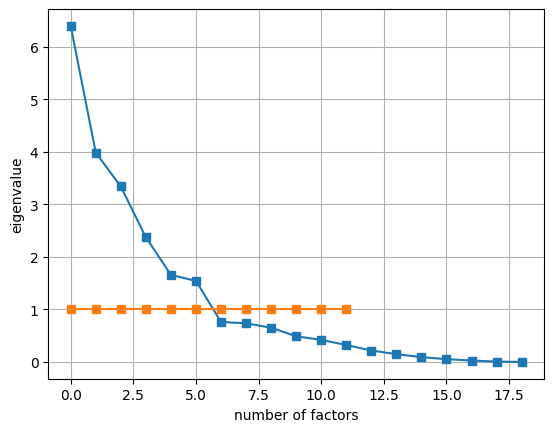

In [11]:
# 因子数の決定
ev = pca.explained_variance_

ev_1 = np.ones(12)

plt.plot(ev, 's-')   
plt.plot(ev_1, 's-') 

plt.xlabel("number of factors")
plt.ylabel("eigenvalue")

plt.grid()
plt.show()


In [12]:
from sklearn.decomposition import FactorAnalysis as FA

n_components=5

fa = FA(n_components, max_iter=5000)
fitted = fa.fit_transform(z)

print(fitted)
print(fitted.shape)


[[ 0.83462535  1.45900861  2.79798481 -0.68152087 -0.39050211]
 [-0.25241308  0.66514432  0.20883742 -0.2743482  -0.68234572]
 [ 1.95483813 -0.81603416 -0.32092745  0.73157973 -0.80181394]
 [ 1.32877267 -0.53778368 -0.25045535 -1.17931744  0.24262691]
 [ 1.09372376 -1.50349275 -0.35096252 -1.18274948  0.3817975 ]
 [-0.99984735 -0.55113437  0.79606981  0.02688455  1.07427661]
 [ 1.25422377  0.86187585  0.9713084   1.63706055  0.52508943]
 [-0.23100798 -1.18289866  0.52274547 -0.46954882  0.03098646]
 [ 0.69782959 -0.29604523 -0.57996583 -0.38374049 -0.53839577]
 [-0.41079992 -0.56954438  0.48977822 -0.07707502  0.06704499]
 [-0.04971385 -1.27749435 -0.80921918  0.79838048 -1.95574413]
 [-0.36210063 -0.22659892 -0.77551359  2.67304647  1.24519307]
 [-1.36223921 -1.17366254  0.84988095  0.42550185  0.44692571]
 [ 0.45433314  0.97751293 -1.73804987 -1.22489419  2.34062621]
 [-1.28664321  0.60680403 -0.22095477 -0.8758722  -0.82885434]
 [ 0.50168266  2.24447405 -1.25767109  0.48846118 -0.89

In [13]:
# 因子負荷量行列
Factor_loading_matrix = fa.components_.T

pd.DataFrame(Factor_loading_matrix, 
                columns=["first", "second", "third", "fourth", "fifth"], 
                index=[fa_data.columns])

,first,second,third,fourth,fifth
X1,0.300126,-0.760240,0.549616,0.131819,0.030481
X2,0.061771,0.089385,0.422658,-0.080340,0.694673
X3,-0.119514,0.227434,0.180082,-0.332312,-0.127423
X4,0.285610,0.174824,0.526007,-0.087605,0.552013
X5,-0.371871,-0.270752,0.422867,0.315150,-0.294720
X6,-0.513501,-0.003081,0.149956,-0.619604,0.095768
X7,-0.332877,0.125350,0.428510,-0.723371,0.163962
X8,-0.163762,0.090253,0.459149,0.429569,-0.460486
X9,0.156335,-0.230758,0.373536,-0.095727,-0.423853
X10,-0.236393,-0.216784,0.702191,0.283846,0.285782


### 定量的分析

In [18]:
#shapiro test
from scipy import stats

W, shapiro_p_value = stats.shapiro(aov_data["金額"])
print(f'Shapiro-Wilk test statistic: {W}, p-value: {shapiro_p_value}')

Shapiro-Wilk test statistic: 0.89255690574646, p-value: 0.035751406103372574


In [21]:
# mannwhitney U test
from scipy.stats import mannwhitneyu

human = aov_data[aov_data["店員"] == "人"]
robot = aov_data[aov_data["店員"] == "ロボット"]

mannwhitneyu(human["金額"], robot["金額"], alternative='two-sided')

MannwhitneyuResult(statistic=53.5, pvalue=0.5098934717924304)

In [23]:
# kruskal wallis H-test
from scipy.stats import kruskal

h, p = kruskal(human["金額"], robot["金額"])
print("F=%f, p-value = %f"%(h,p))

F=0.490268, p-value = 0.483808


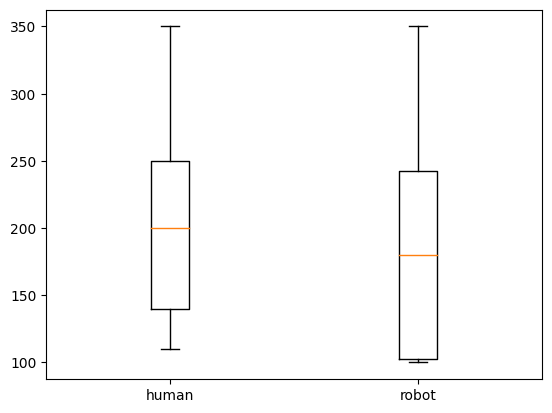

In [17]:
# 分布
plt.boxplot([human["金額"], robot["金額"]], labels=['human', 'robot'])
plt.show()